## Task 1: Data dimensionality, distance-based classifiers
Purpose: to develop some intuitions about clouds of points in high-dimensional spaces.
In particular, you are supposed to use dimensionality reduction techniques to visualize your data, develop a
very simple algorithm for classifying hand-written digits and compare it to another distance-based classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#reading in data
test_in_path   = 'C:/Users/Peter/Desktop/Leiden/DeepLearning/A1_data/test_in.csv'
test_out_path  = 'C:/Users/Peter/Desktop/Leiden/DeepLearning/A1_data/test_out.csv'
train_in_path  = 'C:/Users/Peter/Desktop/Leiden/DeepLearning/A1_data/train_in.csv'
train_out_path = 'C:/Users/Peter/Desktop/Leiden/DeepLearning/A1_data/train_out.csv'

test_set     = np.loadtxt(test_in_path, delimiter=',')
test_labels  = np.loadtxt(test_out_path, delimiter=',')
train_set    = np.loadtxt(train_in_path, delimiter=',')
train_labels = np.loadtxt(train_out_path, delimiter=',')

In [3]:
ind = np.where(train_labels == 0)
test = train_set[ind]
print(test.shape)
m = test.sum(axis=0) / len(ind)
len(m)

(319, 256)


256

For each cloud we can calculate its center, cd: a 256-dimensional vector of means over all coords of vectors that belong to Cd. Once we have these centers, we can easily classify new images: by calculating the distance from the vector that represents this image to each of the 10 centers, the closest center defines the label of the image. 

In [4]:
#digit d 
d = np.arange(0,10)

#cloud of points in 256 dimensional space = Cd
Cd = np.zeros((10, 256)) 
x = Cd.shape
print(x)

#finding the center of each cloud ----> distance-based classifier
for i in d:
    ind = np.where(train_labels == i)
    cd = train_set[ind]
    mean = cd.sum(axis=0) / len(ind[0])
    Cd[i] = mean
    
#distances between the centers of each cloud
dist_arr = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        dist_arr[i,j] = np.linalg.norm(Cd[i] - Cd[j])

(10, 256)


In [5]:
dist_arr

array([[ 0.        , 14.44960797,  9.33455587,  9.14373367, 10.76984444,
         7.51929626,  8.15444313, 11.86455505,  9.90790174, 11.48887494],
       [14.44960797,  0.        , 10.12532258, 11.7332329 , 10.17378643,
        11.11880041, 10.61470037, 10.74315367, 10.08677677,  9.9320937 ],
       [ 9.33455587, 10.12532258,  0.        ,  8.17828489,  7.93254148,
         7.90679632,  7.33180754,  8.87253107,  7.07751618,  8.88774785],
       [ 9.14373367, 11.7332329 ,  8.17828489,  0.        ,  9.0876078 ,
         6.11875002,  9.30206473,  8.92240093,  7.02042489,  8.35435012],
       [10.76984444, 10.17378643,  7.93254148,  9.0876078 ,  0.        ,
         8.00151741,  8.78223265,  7.58301228,  7.38090899,  6.01040793],
       [ 7.51929626, 11.11880041,  7.90679632,  6.11875002,  8.00151741,
         0.        ,  6.69869172,  9.21195402,  6.96738648,  8.25853807],
       [ 8.15444313, 10.61470037,  7.33180754,  9.30206473,  8.78223265,
         6.69869172,  0.        , 10.8882374 

In [6]:
# What pairs of digits seem to be most difficult to separate?
def difficult_pair(dist_arr):
    x = np.where(dist_arr == 0)
    dist_arr[x] += 100
    return np.where(dist_arr == np.amin(dist_arr))

print(difficult_pair(dist_arr))
print('\n4 and 9 will be difficult to separate')

(array([7, 9], dtype=int64), array([9, 7], dtype=int64))

4 and 9 will be difficult to separate


In [7]:
#Testing accuracy of the distance-based classifier
def accuracy():
    dtrain = np.zeros((len(train_set), 10))
    dtest = np.zeros((len(test_set), 10))

    for i in range(10):
        d = np.linalg.norm(Cd[i] - train_set, axis=1)
        dtrain[:,i] = d
        d = np.linalg.norm(Cd[i] - test_set, axis=1)
        dtest[:,i] = d

    train_min = []
    test_min = []
    for d in dtrain:
        train_min.append(np.argmin(d)) #Returns the indices of the minimum values along the axis
    for d in dtest:
        test_min.append(np.argmin(d))

    train_predictors = train_labels - train_min
    train_success = np.count_nonzero(train_predictors==0)
    train_accuracy = (train_success / len(train_set)) * 100

    test_predictors = test_labels - test_min
    test_success = np.count_nonzero(test_predictors==0)
    test_accuracy = (test_success / len(test_set)) * 100

    print('Training set accuracy:', round(train_accuracy, 1), '%')
    print('Test set accuracy:', round(test_accuracy, 1), '%')
    
    return(train_min, test_min)

dist_train_predictors, dist_test_predictors = accuracy()

Training set accuracy: 86.4 %
Test set accuracy: 80.4 %


In [8]:
plt.rcdefaults()

## Dimensionality reduction algorithms

For toy problems such as the S-curve we saw before, **locally linear embedding (LLE)** and its variants (especially modified LLE), perform very well. This is implemented in sklearn.manifold.LocallyLinearEmbedding.


For high-dimensional data from real-world sources, LLE often produces poor results, and **isometric mapping (IsoMap)** seems to generally lead to more meaningful embeddings. This is implemented in sklearn.manifold.Isomap


For data that is highly clustered, **t-distributed stochastic neighbor embedding (t-SNE)** seems to work very well, though can be very slow compared to other methods. This is implemented in sklearn.manifold.TSNE

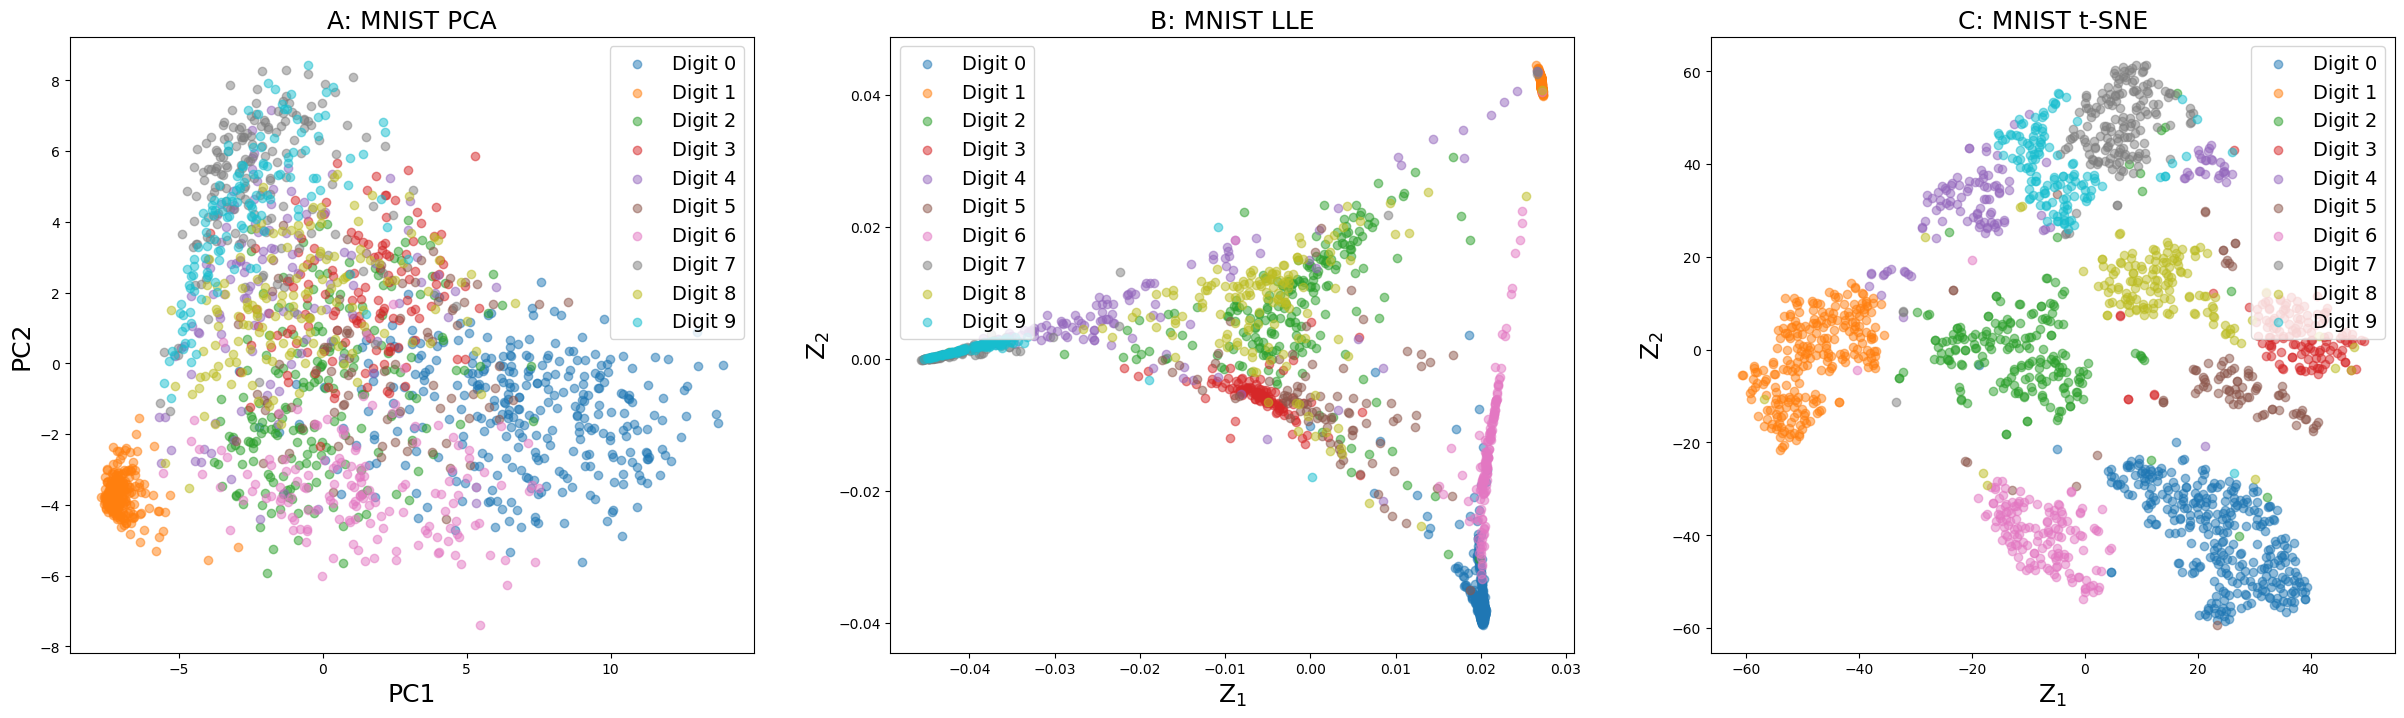

In [9]:
#Plotting all dimensionality reduction algos

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,8])
#fig = plt.figure(figsize=[15,15])
#gs = gridspec.GridSpec(2, 4, wspace=0.5)
#ax1 = fig.add_subplot(gs[0, :2], )
#ax2 = fig.add_subplot(gs[0, 2:])
#ax3 = fig.add_subplot(gs[1, 1:3])

#PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(train_set) #principal components
for i in range(10):
    ind = np.where(train_labels == i)
    ax1.scatter(pc[ind,0], pc[ind,1], alpha = 0.5, label = 'Digit '+str(i))
    
ax1.set_xlabel('PC1', fontsize=18)
ax1.set_ylabel('PC2', fontsize=18)
ax1.set_title('A: MNIST PCA', fontsize=18)
ax1.legend(fontsize=14)

#LLE
model = LLE(n_components=2, n_neighbors=10)
lle = model.fit_transform(train_set)
for i in range(10):
    ind = np.where(train_labels == i)
    ax2.scatter(lle[ind,0], lle[ind,1], alpha = 0.5, label = 'Digit '+str(i))
    
ax2.set_xlabel(r'Z$_{1}$', fontsize=18)
ax2.set_ylabel(r'Z$_{2}$', fontsize=18)
ax2.set_title('B: MNIST LLE', fontsize=18)
ax2.legend(fontsize=14)

#t-SNE
model = TSNE(n_components=2)
tsne = model.fit_transform(train_set)
for i in range(10):
    ind = np.where(train_labels == i)
    ax3.scatter(tsne[ind,0], tsne[ind,1], alpha = 0.5, label = 'Digit '+str(i))

ax3.set_xlabel(r'Z$_{1}$', fontsize=18)
ax3.set_ylabel(r'Z$_{2}$', fontsize=18)
ax3.set_title('C: MNIST t-SNE', fontsize=18)
ax3.legend(fontsize=14)

plt.show()

In [10]:
#Principle component analysis

def pca(training_data, labels):
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    pc = pca.fit_transform(train_set) #principal components
    
    plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    plt.xlabel('1st Principle Component')
    plt.ylabel('2nd Principle Component')
    plt.title('MNIST PCA')
    
    for i in range(10):
        ind = np.where(labels == i)
        plt.scatter(pc[ind,0], pc[ind,1], alpha = 0.5, label = 'Digit '+str(i), s=20)

    plt.legend()
    plt.show()
    
#pca(train_set, train_labels)

In [11]:
#Locally Linear Embedding (LLE) - https://blog.paperspace.com/dimension-reduction-with-lle/ 
#https://github.com/asdspal/dimRed/blob/master/LLE.ipynb

def lle(training_data, labels):
    from sklearn.manifold import LocallyLinearEmbedding as LLE
    model = LLE(n_components=2, n_neighbors=10)
    lle = model.fit_transform(training_data)
    
    plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    plt.title('MNIST LLE')
    
    for i in range(10):
        ind = np.where(labels == i)
        plt.scatter(lle[ind,0], lle[ind,1], alpha = 0.5, label = str(i))

    plt.legend()
    plt.show()

#lle(train_set, train_labels)

t-SNE not only captures the local structure of the higher dimension but also preserves the global structures of the data like clusters. It has stunning ability to produce well-defined segregated clusters. 

- t-SNE is based on stochastic neighbor embedding(SNE). 
- t-SNE was developed to address some of the problems in SNE.
- SNE: stochastic neighbor embedding uses a probabilistic approach to embed a high dimension dataset into lower dimension by preserving the neighborhood structure of the dataset. 
- A Gaussian probability distribution centered on each point is defined over all the potential neighbors of this point. 
- SNE aims to minimize the difference in probability distribution in the higher dimension and lower dimension.

In [12]:
#t-distributed stochastic neighbor embedding (t-SNE)

def tsne(training_data, labels):
    from sklearn.manifold import TSNE
    model = TSNE(n_components=2)
    tsne = model.fit_transform(training_data)
    
    plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    plt.title('MNIST t-SNE')
    
    for i in range(10):
        ind = np.where(labels == i)
        plt.scatter(tsne[ind,0], tsne[ind,1], alpha = 0.5, label = str(i))

    plt.legend()
    plt.show()

#tsne(train_set, train_labels)

In [13]:
#K-Nearest-Neighbor (KNN)
def knn(training_data, train_labels, testing_data, test_labels):
    
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier() 
    knn.fit(training_data, train_labels)
    
    train_knn_predictions = knn.predict(training_data)
    train_predictors = train_labels - train_knn_predictions
    train_success = np.count_nonzero(train_predictors==0) 
    train_accuracy = train_success / len(training_data) * 100
    
    test_knn_predictions = knn.predict(testing_data)
    test_predictors = test_labels - test_knn_predictions
    test_success = np.count_nonzero(test_predictors==0)
    test_accuracy = test_success / len(testing_data) * 100

    print('KNN training set accuracy:', round(train_accuracy, 1), '%')
    print('KNN testing set accuracy:', round(test_accuracy, 1), '%') 
    
    return(train_knn_predictions, test_knn_predictions)
    
knn_train_predictors, knn_test_predictors = knn(train_set, train_labels, test_set, test_labels)

KNN training set accuracy: 96.6 %
KNN testing set accuracy: 90.8 %


For both classifiers generate a confusion matrix which should provide a deeper insight into classes that are difficult to separate. A confusion matrix is here a 10-by-10 matrix, **c_ij**, which contains the percentage (or count) of digits **i** that are classified as **j**. 

Which digits are most difficult to classify correctly? Again, for calculating and visualising confusion matrices you may use the sklearn package. Describe your findings, compare performance of your classifiers on the train and test sets.

In [14]:
def confusion(training_data, train_labels, testing_data, test_labels):
    from sklearn.metrics import confusion_matrix
    
    dist_cm_train = confusion_matrix(train_labels, dist_train_predictors) 
    dist_cm_test = confusion_matrix(test_labels, dist_test_predictors) 
    
    knn_cm_train = confusion_matrix(train_labels, knn_train_predictors) 
    knn_cm_test = confusion_matrix(test_labels, knn_test_predictors) 
    
    print('\nConfusion Matrix using the distance-based classifier on the training data:\n\n', dist_cm_train)
    print('\nConfusion Matrix using the distance-based classifier on the test data:\n\n', dist_cm_test)
    print('\nConfusion Matrix using the KNN classifier on the training data:\n\n', knn_cm_train)
    print('\nConfusion Matrix using the KNN classifier on the test data:\n\n', knn_cm_test)
    
    return dist_cm_train, dist_cm_test, knn_cm_train, knn_cm_test

dist_cm_train, dist_cm_test, knn_cm_train, knn_cm_test = confusion(train_set, train_labels, test_set, test_labels)   


Confusion Matrix using the distance-based classifier on the training data:

 [[271   0   0   0   2   4  36   0   6   0]
 [  0 252   0   0   0   0   0   0   0   0]
 [  3   0 167   9   9   1   3   4   6   0]
 [  0   0   2 120   1   3   0   1   3   1]
 [  0   8   1   0  95   0   3   0   0  15]
 [  3   0   2   3   4  67   3   1   2   3]
 [ 10   4   5   0   2   0 129   0   1   0]
 [  0   4   0   0   2   2   0 140   1  17]
 [  1   2   1  10   2   3   1   0 121   3]
 [  0   3   0   1  10   0   0   6   0 112]]

Confusion Matrix using the distance-based classifier on the test data:

 [[178   0   3   2   4   2  23   1  10   1]
 [  0 120   0   0   0   0   1   0   0   0]
 [  2   0  69   6   8   1   0   2  13   0]
 [  3   0   3  61   1   8   0   0   1   2]
 [  1   3   3   0  69   0   1   1   0   8]
 [  3   0   0   6   3  38   1   0   0   4]
 [  7   0   2   0   2   1  78   0   0   0]
 [  0   2   1   0   5   0   0  50   0   6]
 [  3   2   0   6   3   3   0   0  73   2]
 [  0   5   0   0   8   0   0 

In [15]:
#Which digits are most difficult to classify correctly?
def difficult_digits(classifier):
    idx=[]
    vals=[]
    for i in range(10):
        diag = classifier[i,i]
        s = classifier[i].sum()
        idx.append(i)
        vals.append(diag/s)
    x=vals.index(min(vals))
    print(idx[x], min(vals))
    
difficult_digits(dist_cm_train)
difficult_digits(dist_cm_test)
difficult_digits(knn_cm_train)
difficult_digits(knn_cm_test)   

5 0.7613636363636364
2 0.6831683168316832
8 0.8958333333333334
5 0.6363636363636364


## Task 2: Implement a multi-class perceptron algorithm

Implement (from scratch) a multi-class perceptron training algorithm (from slide 36, second lecture) and
use it for training a single layer perceptron with 10 nodes (one per digit), each node having 256+1 inputs
(inputs and bias) and 1 output. Train your network on the train set and evaluate on both the train and the
test set, in the same way as you did in the previous task. As your algorithm is non-deterministic (results
depend on how you initialize weights), repeat your experiments a few times to get a feeling of the reliability
of your accuracy estimates.


Try to make your code efficient. In particular, try to limit the number of loops, using matrix multiplication
whenever possible. For example, append to your train and test data a column of ones that will represent
the bias. The weights of your network can be stored in a matrix W of size 257x10. Then the output of the
network on all inputs is just a dot product of two matrices: T rain and W, where T rain denotes the matrix
of all input vectors (one per row), augmented with 1’s (biases). To find the output node with the strongest
activation use the numpy argmax function. An efficient implementation of your algorithm shouldn’t take
more than a few seconds to converge on the training set (yes, the training set consists of patterns that are
linearly separable so the perceptron algorithm will converge).


How does the accuracy of this single layer multi-class perceptron compare to the distance based methods
in task 1?

In [16]:
def perceptron(train_data, train_labels, test_data, test_labels):

    inputs = 256
    outputs = 10
    w = np.random.uniform(low=-1, high=1, size=(outputs,inputs)) #weights will be random
    b = np.ones(outputs) #bias
    
    convergence = 0
    while convergence < len(train_data):
    
        for data_in, label in zip(train_data, train_labels):
            predictions = np.dot(w, data_in) + b  #generating predictions for each entry
            best_prediction = np.argmax(predictions) #e.g. if index 3 is highest number --> predicting a digit 3
            
            if best_prediction != label:
                overshoots = np.where(predictions > predictions[int(label)]) #predictions greater than target
                w[overshoots] -=  data_in 
                w[int(label)] += data_in #can disregard predictions less than target 
                convergence = 0
                
            else:
                convergence += 1
    
    return w, b

w, b = perceptron(train_set, train_labels, test_set, test_labels)

In [17]:
# Train set
predictions_train = []
for i in range(len(train_set)):
    predictions = np.dot(w, train_set[i]) + b 
    best_prediciton = np.argmax(predictions)
    predictions_train.append(best_prediciton)

predictors_train = predictions_train - train_labels
success_train = np.count_nonzero(predictors_train == 0)
accuracy_train = success_train / len(train_set) * 100

print('The accuracy on the training set is:', accuracy_train, '%')

# Test set
predictions_test = []
for i in range(len(test_set)):
    z = np.dot(w, test_set[i]) + b 
    y_out = np.argmax(z)
    predictions_test.append(y_out)

predictors_test = predictions_test - test_labels
success_test = np.count_nonzero(predictors_test == 0)
accuracy_test = success_test / len(test_set) * 100

print('The accuracy on the test set is:', accuracy_test, '%')

The accuracy on the training set is: 100.0 %
The accuracy on the test set is: 86.0 %


### Task 3: Implement the XOR network and the Gradient Descent Algorithm

In [2]:
#defining all the necessary functions that are used in the neural network

#==========================================================================================================

#function that initialized the weights and biases
def generate_weights(): 
    N0 = 2 #input layer size
    N1 = 2 #hidden layer size
    N2 = 1 #output layer size

    #weights and biases
    #from input layer to hidden layer:
    w1 = np.random.uniform(low = -1, high = +1, size = (N1, N0)) # random weights: N1xN0
    b1 = np.ones(N1) # biases: N1 vector

    
    #weights+biases from hidden layer to output layer:
    #random weights
    w2 = np.random.uniform(low = -1, high = +1, size = (N1, N2)) # random weights: N1xN2
    b2 = np.ones(N2) # biases: N2 vector
    
    return w1, w2, b1, b2
    
#==========================================================================================================

#computes the activation function - possible activation functions are sigmoid, tanh and relu
def act_function(z, name):
    if name == 'sigmoid':
        return 1 / (1 + np.exp(-z))
    elif name == 'tanh':
        return np.tanh(z)
    elif name == 'relu':
        out = np.zeros(z.shape)
        i = np.where(z > 0)
        out[i] = z[i]
        return out

#==========================================================================================================    
    
#computes the derivative of the activation function
def act_function_der(y, name):
    if name == 'sigmoid':
        return y*(1.0 - y)
    elif name == 'tanh':
        return 1 - y**2
    elif name == 'relu':
        out = np.zeros(y.shape)
        i = np.where(y > 0)
        out[i] = 1
        return out
        
#==========================================================================================================    
        
#simulates the xor network, i.e use this function to do a prediction
def predicting(y_in):
    global w1, w2, b1, b2, act_name
    
    z = np.dot(y_in, w1) + b1     
    y = act_function(z, act_name) #output of hidden nodes
    z = np.dot(y, w2) + b2
    y_out = act_function(z, act_name) #output of output node
    return y_out 

#==========================================================================================================

#computes the mean squared error between the prediction and the target value
def mse(y_in, d):     #d is the target output 
    y_out = predicting(y_in)    #get a prediction using the input y_in
    return 0.5 * (y_out - d)**2   #definition of mse

#==========================================================================================================

#computes the gradient of mse and computes the necessary changes of the weights and biases
#for backpropagation
def grdmse(y_in, d):   #d is the target output
    global w1, w2, b1, b2, act_name
    
    y_h = act_function(np.dot(y_in, w1) + b1, act_name)  #output of hidden nodes
    y_out = act_function(np.dot(y_h, w2) + b2, act_name) #output of output node
    
    #backpropagation now begins here
    y_out_err= y_out - d     #error in the output
    y_out_delta = np.multiply(y_out_err, act_function_der(y_out, act_name))
    
    y_h_err = np.dot(y_out_delta, w2.T)
    y_h_delta = np.multiply(y_h_err, act_function_der(y_h, act_name))
    
    
    dw1 = np.dot(y_in.T, y_h_delta)   #change for the input to hidden layer weigths
    dw2 = np.dot(y_h.T, y_out_delta)  #change for the hidden to output layer weigths
    
    db1 = y_h_delta.sum(0)       #change in the biases for the hidden nodes
    db2 = y_out_delta.sum(0)     #change in the bias for the output node
    
    return dw1, dw2, db1, db2

#==========================================================================================================

#updates the weigths and biases using gradient descent 
def gda(y_in, d, eta):   #eta is the learning rate
    global w1, w2, b1, b2
    dw1, dw2, db1, db2 = grdmse(y_in, d)   #changes in the weights and biases
    
    #update the weights and biases
    w1 -= eta * dw1
    w2 -= eta * dw2
    b1 -= eta * db1
    b2 -= eta * db2
    

In [3]:
def xor():
    global w1, w2, b1, b2
    inputs=np.array([[0, 0], [0, 1], [1, 0], [1, 1] ])   #training set
    outputs=np.array([ [0], [1], [1], [0] ])     #targets of training set 

    w1, w2, b1, b2 = generate_weights()   #initialize the weights
    #act_name = 'sigmoid'
    #act_name = 'tanh'
    #act_name = 'relu'

    epochs = 50000    #for how many epochs you want to train the network
    eta = 1           #learning rate
    mean_error = []   #this list keeps track of the mean_error during training 
    right = 0         #keeps track of number of right predictions
    wrong = 0         #keeps track of number of wrong predictions

    #train the network
    for i in range(epochs):
        error = mse(inputs, outputs).sum() / 4
        mean_error.append(error)
        gda(inputs, outputs, 1)
        y_out = predicting(inputs)

        y_out_rounded = np.around(y_out, decimals=0)
        wrong += (abs(y_out_rounded - outputs)).sum()
        right += 4 - (abs(y_out_rounded - outputs)).sum()
            
    return mean_error

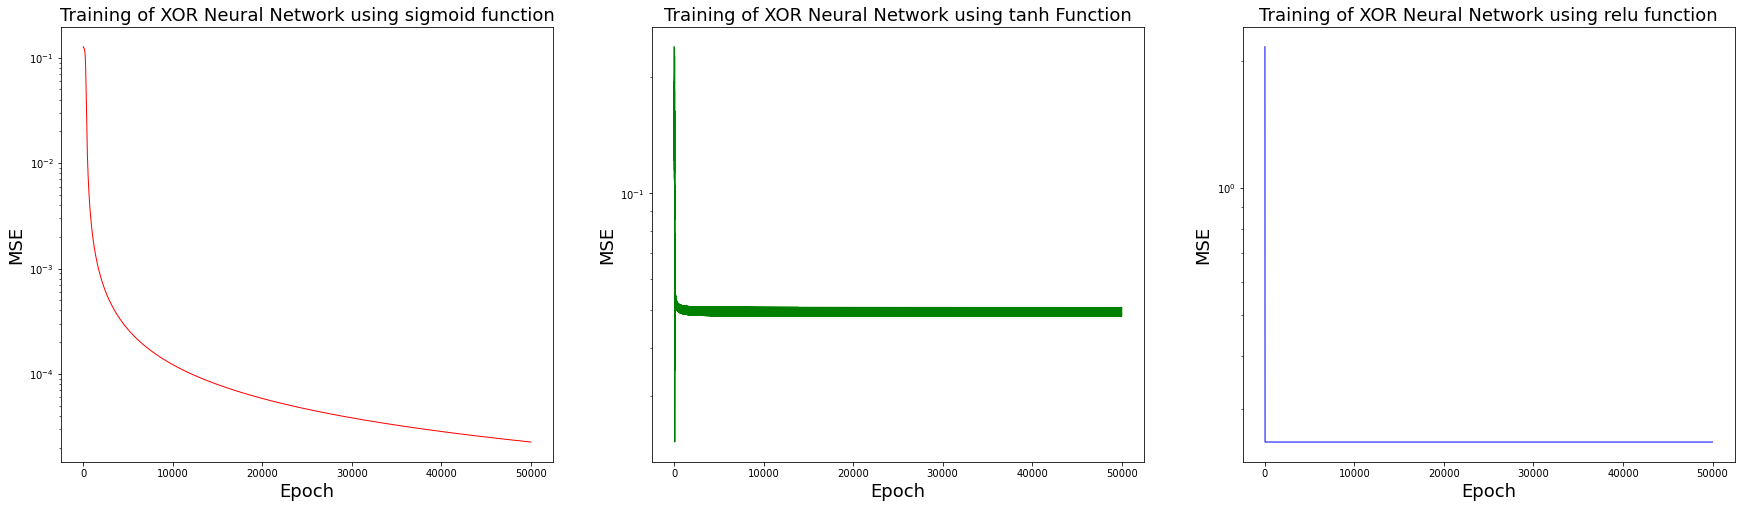

In [10]:
#Plotting task3
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,8])

#sigmoid
act_name = 'sigmoid'
err_sig = xor()
ax1.semilogy(np.linspace(0, 50000, 50000), err_sig, linewidth=1, color='r')
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('MSE', fontsize=18)
ax1.set_title('Training of XOR Neural Network using sigmoid function', fontsize=18)

#tanh
act_name = 'tanh'
err_tanh = xor()
ax2.semilogy(np.linspace(0, 50000, 50000), err_tanh, linewidth=1, color='g')
ax2.set_xlabel('Epoch', fontsize=18)
ax2.set_ylabel('MSE', fontsize=18)
ax2.set_title('Training of XOR Neural Network using tanh Function', fontsize=18)

#relu
act_name = 'relu'
err_relu = xor()
ax3.semilogy(np.linspace(0, 50000, 50000), err_relu, linewidth=1, color='b')
ax3.set_xlabel('Epoch', fontsize=18)
ax3.set_ylabel('MSE', fontsize=18)
ax3.set_title('Training of XOR Neural Network using relu function', fontsize=18)

plt.show()

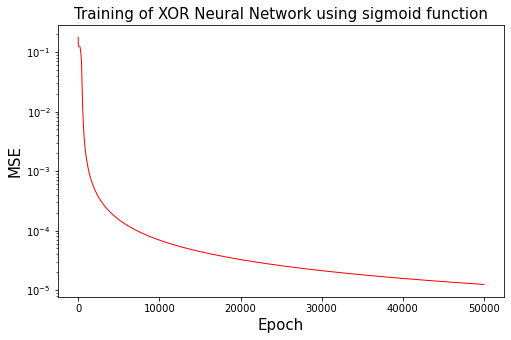

In [4]:
plt.figure(figsize=(8,5))
act_name = 'sigmoid'
err_sig = xor()
plt.plot(np.linspace(0, 50000, 50000), err_sig, linewidth=1, color='r')
plt.yscale('log')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Training of XOR Neural Network using sigmoid function', fontsize=15)
plt.show()

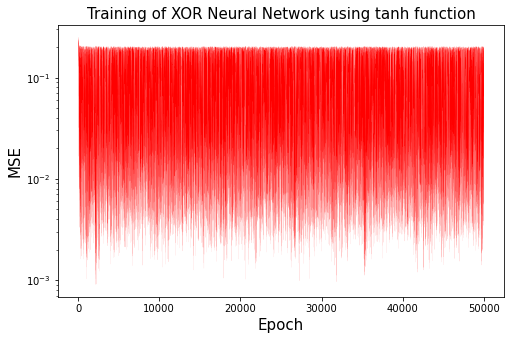

In [17]:
plt.figure(figsize=(8,5))
act_name = 'tanh'
err_tanh = xor()
plt.plot(np.linspace(0, 50000, 50000), err_tanh, linewidth=0.05, color='r')
plt.yscale('log')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Training of XOR Neural Network using tanh function', fontsize=15)
plt.show()

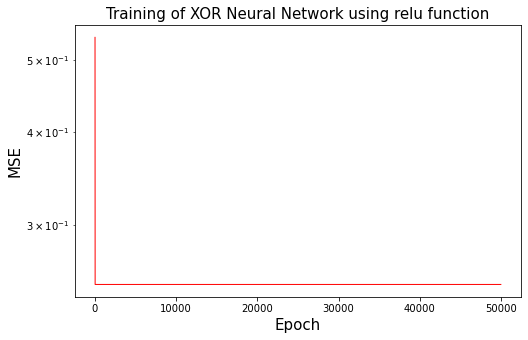

In [7]:
plt.figure(figsize=(8,5))
act_name = 'relu'
err_relu = xor()
plt.plot(np.linspace(0, 50000, 50000), err_relu, linewidth=1, color='r')
plt.yscale('log')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.title('Training of XOR Neural Network using relu function', fontsize=15)
plt.show()